# THIS CODE CONCATENATES ARBITRARILY 

In [1]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

/Users/s2537809/DESI/desispec/py/desispec/qproc/qextract.py:19: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_extract(image_flux,image_var,x,hw=3) :
/Users/s2537809/DESI/desispec/py/desispec/image_model.py:27: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def numba_proj(image,x,sigma,flux) :
/Users/s2537809/DESI/desispec/py/desispec/preproc.py:379: Num

## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [2]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

In [74]:
#stacking functions

# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Cutting crossover between arms (arbitarilly intially)

        new_b_length = np.where(coadd_spec.wave['b']<coadd_spec.wave['r'][0])
        b_wave = coadd_spec.wave['b'][new_b_length]
        b_flux = coadd_spec.flux['b'][0][new_b_length]
        new_r_length = np.where(coadd_spec.wave['r']<coadd_spec.wave['z'][0])
        r_wave = coadd_spec.wave['r'][new_r_length]
        r_flux = coadd_spec.flux['r'][0][new_r_length]
        z_wave = coadd_spec.wave['z']
        z_flux = coadd_spec.flux['z'][0]

        # Concatenating spectra

        flux_spectra = np.concatenate((b_flux,r_flux,z_flux))
        wave_spectra = np.concatenate((b_wave,r_wave,z_wave))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()

    
    
    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [75]:

"""
#presort by mass to bin by mass 

Mass_median = crossmatch['Mass_median']
mass_order_idx = np.argsort(crossmatch['Mass_median'])
sorted_mass = Mass_median[mass_order_idx]
crossmatch = crossmatch[np.array(mass_order_idx)]


Overall_class = 'LERG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:10]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


"""

# Select varibale to sort by
#Mass_median or Total_flux from LOFAR?

var_bin = 'Mass_median'
crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]

Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][4000:5000]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


SFG_spec=get_spectra(my_table,search_column_name,search_values) #extracts relevant spectra

SFG_stack = get_stack(SFG_spec) #stacks spectra

#stack spectra in two redshift bins (i.e 0<z<0.1 and 0.1<z<0.2) - need to alter
SFG_stacks = get_stack(SFG_spec, zbins=[[0.0,0.5],[0.5,1.0],[1.0,4.0]])
#soemtimes the redshift is less than 0?

## try adjusting these boundarys and adding more bins instead of binning seperately

Number of spectra = 1000
[ 9.26403725e-01  5.58516835e-01  7.72876649e-01  5.58403574e-01
  2.58271269e-01  2.50074500e-01  6.15396425e-01  1.26018056e+00
  6.36726370e-01 -1.99570145e-03  2.63261524e-01  3.35949982e-01
  3.98526912e-01  3.22170726e-01  1.00266133e+00  7.90634196e-01
  1.08664016e+00  5.41970767e-01 -1.99570145e-03  1.47131502e-01
  4.95889720e-01  3.95847423e-01  5.52690433e-01 -1.99570145e-03
  1.19992546e+00 -1.99570145e-03  2.68370335e-01  9.99148859e-01
  5.58477104e-01  4.50106367e-01  1.38977244e+00  5.09921442e-01
 -1.99570145e-03  4.53260190e-01  2.66702495e-01  4.82646737e-01
  1.01611744e+00  6.64445409e-01  1.14795232e+00  6.73532679e-01
  3.77864332e-01  3.26752756e-01  1.21022862e+00  3.57475424e-01
  1.26885107e+00  3.28431322e-01  6.26889681e-01  9.49917728e-01
  3.52231196e-01 -1.99570145e-03  4.17616263e-01  4.42449784e-01
  4.79921772e-01  1.18193884e+00  3.99164235e-01  2.91195002e-01
  9.74624965e-01  3.80073536e-01 -1.99570145e-03  4.48080658e-01


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_15122/841989989.py:86: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 0.869 sec to read coadd-sv1-other-11520.fits at 2024-01-05T17:26:59.257740
INFO:spectra.py:372:read_spectra: iotime 0.584 sec to read coadd-sv1-other-10147.fits at 2024-01-05T17:27:00.289862
INFO:spectra.py:372:read_spectra: iotime 0.817 sec to read coadd-sv1-other-10156.fits at 2024-01-05T17:27:01.256667
INFO:spectra.py:372:read_spectra: iotime 2.039 sec to read coadd-sv3-bright-10154.fits at 2024-01-05T17:27:03.477901
INFO:spectra.py:372:read_spectra: iotime 2.670 sec to read coadd-sv3-bright-10158.fits at 2024-01-05T17:27:07.777291
INFO:spectra.py:372:read_spectra: iotime 0.585 sec to read coadd-sv1-other-10147.fits at 2024-01-05T17:27:10.084611
INFO:spectra.py:372:read_spectra: iotime 0.749 sec to read coadd-sv1-other-10150.fits at 2024-01-05T17:27:11.081785
INFO:spectra.py:372:read_spectra: iotime 2.323 sec to read coadd-sv3-dark-10155.fits at 2024-01-05T17:27:13.890565
INFO:spectra.py:372:read_spectra: iotime 0.649 sec to read coadd-sv1-ot

/Users/s2537809/Documents/DESI-STACKING/stack_code.py:247: RuntimeWarning: invalid value encountered in divide
  Fnorm = flux_new / np.median(flux_new[:, norm_range], axis=1, keepdims=True)


Stack[0]: [ 0.41906702 -0.3946848   0.19742387 ...         nan         nan
         nan]
Stack[1]: [ 0.41906702 -0.3946848   0.19742387 ...         nan         nan
         nan]
Stack[2]: [  1.   1.   1. ... 107. 107.  52.]
flux_spec: [array([-0.09043791, -1.28200042, -0.98994279, ...,  0.48350137,
         0.56107891,  0.70605016])
 array([0.64614725, 1.31280863, 4.58564901, ..., 1.11570406, 0.40840042,
        1.07288134])
 array([ 3.3267014 , -0.59044647, -0.41048205, ...,  0.70468313,
        -0.0078227 ,  0.54045767])
 array([0.30962378, 0.84406167, 1.62723863, ..., 0.48512307, 0.69546711,
        0.56479096])
 array([13.97208977,  0.36609614, -1.24989891, ...,  4.87273264,
         4.99605608,  5.35944414])
 array([-0.52744675, 23.86234474,  0.08080712, ...,  2.72712994,
         1.88928938,  2.04033971])
 array([ 0.74379826,  1.64933169, -1.9055289 , ...,  0.62600613,
         0.55415583,  0.53295881])
 array([ 0.63194293,  1.47501004, -0.90886521, ...,  0.13880062,
         0.2

## Plot Stacked Spectra

All plots saved in DESI-SFG-stacked-plots-practice.pdf


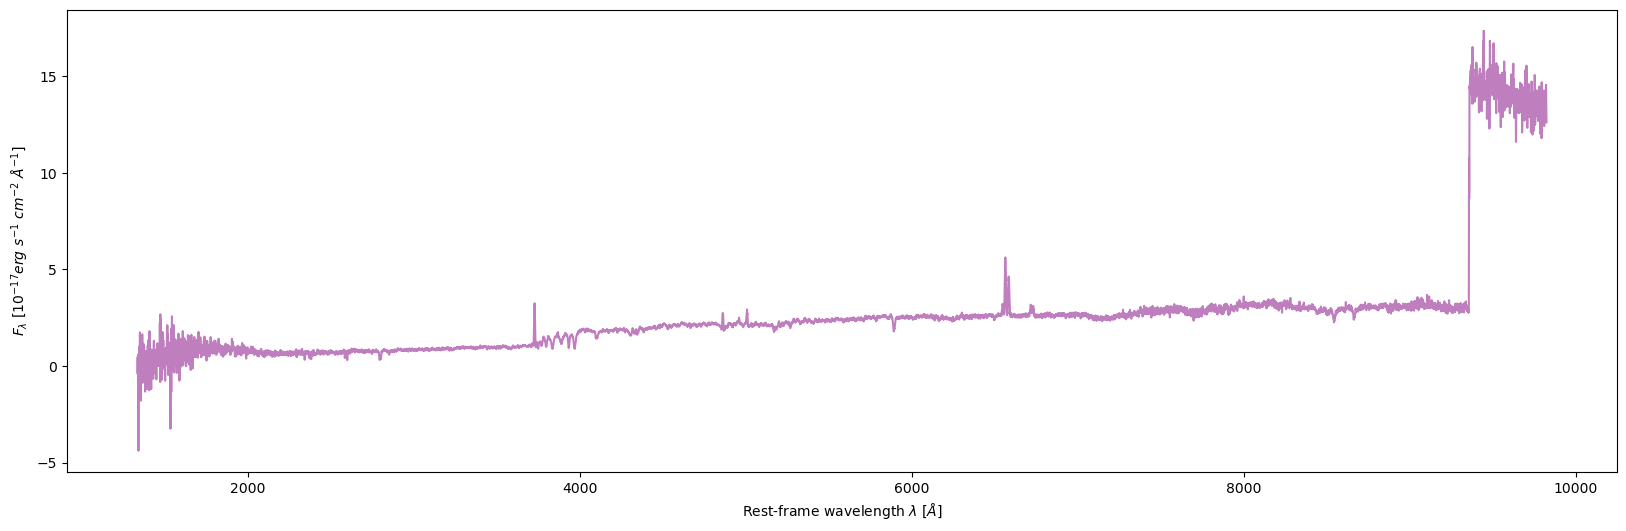

In [76]:
plt.figure(figsize=(20,6))
plt.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='purple', alpha=0.5)
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.xlabel('Rest-frame wavelength $\lambda$ [$\AA$]')

# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-plots-practice.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='purple', alpha=0.5)
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')


### it appears that the problem is with the second half of the rqagn then ?? 
## it is the specifc values and not the size of the range ???


All plots saved in DESI-SFG-stacked-zbin-plots-practice.pdf


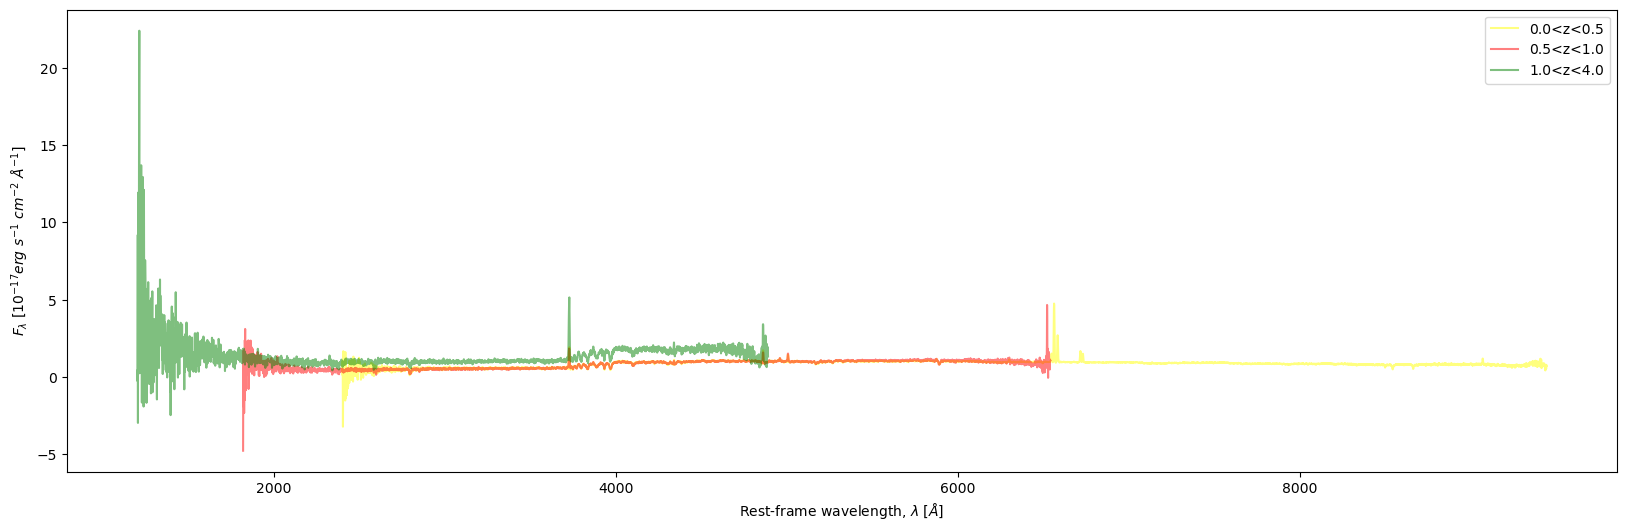

In [43]:
"""

The lack of simulated correction might be having an impact ?
Need to use different redshift bins - why does DESI have negative redshifts?
Why is there such a difference between the bins?

"""


plt.figure(figsize=(20,6))
plt.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label='0.0<z<0.5', color='yellow', alpha=0.5)
plt.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label='0.5<z<1.0', color='red', alpha=0.5)
plt.plot(SFG_stacks['zbin=2']['wln'],SFG_stacks['zbin=2']['flux'], label='1.0<z<4.0', color='green', alpha=0.5)
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
plt.legend()


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-practice.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label='0.0<z<0.5', color='yellow', alpha=0.5)
        ax.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label='0.5<z<1.0', color='red', alpha=0.5)
        ax.plot(SFG_stacks['zbin=2']['wln'],SFG_stacks['zbin=2']['flux'], label='1.0<z<4.0', color='green', alpha=0.5)
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.legend()
     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')